# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install required packages

In [2]:
!pip install obonet

In [3]:
!pip install Bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.6 MB/s eta 0:00:00


In [4]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.2 MB/s eta 0:00:00


In [5]:
!pip install tensorflow==2.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 742.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existin

In [6]:
import tensorflow as tf
print(tf.__version__)

2.8.0


# Import Library

In [7]:
import numpy as np
import pandas as pd
import obonet
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from Bio import SeqIO
from tqdm import tqdm
import warnings
from keras import backend as K

warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load Data

In [ ]:
fasta_path = '/content/drive/MyDrive/TA/Train/train_sequences.fasta'
terms_path = '/content/drive/MyDrive/TA/Train/train_terms.tsv'

fasta_data = pd.DataFrame([(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")], columns=['Protein_ID', 'Sequence'])
terms_data = pd.read_csv(terms_path, sep='\t', header=None, names=['Protein_ID', 'GO_Term_ID', 'Ontology'])

print(fasta_data.shape)
print(terms_data.shape)

(142246, 2)
(5363864, 3)


In [ ]:
terms_data = terms_data[1:]
terms_data.head()

,Protein_ID,GO_Term_ID,Ontology
1,A0A009IHW8,GO:0008152,BPO
2,A0A009IHW8,GO:0034655,BPO
3,A0A009IHW8,GO:0072523,BPO
4,A0A009IHW8,GO:0044270,BPO
5,A0A009IHW8,GO:0006753,BPO


# Load PLM (Pre-Train T5)

In [ ]:
train_protein_ids = np.load('/content/drive/MyDrive/TA/embedding-T5(PLM)/train_ids.npy')
train_protein_ids.shape
train_protein_ids[:10]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366', 'P33681',
       'P77596', 'Q16787', 'Q59VP0', 'P13508'], dtype='<U10')

In [ ]:
# Convert to pandas DataFrame
protein_df = pd.DataFrame(train_protein_ids, columns=['Protein ID'])

train_embeddings = np.load('/content/drive/MyDrive/TA/embedding-T5(PLM)/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
trainT5_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(trainT5_df.shape)

trainT5_df

(142246, 1024)


,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.032529,0.032490,0.026844,0.007486,-0.019346,0.033527,0.048294,-0.091146,0.007092,0.008843,...,-0.038719,-0.037237,-0.022644,-0.055443,0.002142,0.006521,-0.026665,-0.002415,0.016886,0.004104
142242,0.056026,0.035470,0.021987,0.028443,-0.001087,0.020100,-0.010549,-0.049460,0.027347,-0.028113,...,-0.020552,-0.030632,-0.038549,-0.011747,0.060145,0.003906,-0.031132,0.003377,-0.027095,-0.015910
142243,0.016918,0.041331,0.000793,-0.005990,-0.039993,0.056007,-0.013786,-0.076081,0.006320,-0.002054,...,-0.029348,-0.037351,0.008763,-0.051209,0.028266,0.009462,0.019854,0.008808,0.006481,-0.013350
142244,0.061252,0.083402,0.044025,0.047916,0.024477,0.035183,-0.016680,-0.043163,-0.045596,-0.029994,...,-0.014085,0.020183,-0.066376,0.058274,0.056035,-0.002282,-0.013941,0.001384,-0.047546,0.010124


# Preprocessing Data

In [ ]:
merged_data = pd.merge(terms_data, fasta_data[['Protein_ID', 'Sequence']], on='Protein_ID')
merged_data = merged_data[merged_data.Protein_ID.isin(train_protein_ids)]

merged_data

,Protein_ID,GO_Term_ID,Ontology,Sequence
0,A0A009IHW8,GO:0008152,BPO,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
1,A0A009IHW8,GO:0034655,BPO,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
2,A0A009IHW8,GO:0072523,BPO,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
3,A0A009IHW8,GO:0044270,BPO,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
4,A0A009IHW8,GO:0006753,BPO,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...
...,...,...,...,...
5363858,X5E0F1,GO:0005515,MFO,MNKKTKLIHGGHTTDDYTGAVTTPIYQTSTYLQDDIGDLRQGYEYS...
5363859,X5E0F1,GO:0003674,MFO,MNKKTKLIHGGHTTDDYTGAVTTPIYQTSTYLQDDIGDLRQGYEYS...
5363860,X5HMX4,GO:0005515,MFO,MGVTGILQLPRDRFKRTSFFLWVIILFQRTFSIPLGVIHNSTLQVS...
5363861,X5HMX4,GO:0005488,MFO,MGVTGILQLPRDRFKRTSFFLWVIILFQRTFSIPLGVIHNSTLQVS...


In [ ]:
# Set the limit for label
num_of_labels = 1500

# Take value counts in descending order and fetch first 1000 `GO term ID` as labels
labels = merged_data['GO_Term_ID'].value_counts().index[:num_of_labels].tolist()

In [ ]:
# Fetch the train_terms data for the relevant labels only
merged_data_updated = merged_data.loc[merged_data['GO_Term_ID'].isin(labels)]

merged_data_updated.nunique()

Protein_ID    142246
GO_Term_ID      1500
Ontology           3
Sequence      138924
dtype: int64

In [ ]:
# Construct a binary matrix for labels
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in range(10):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = merged_data_updated[merged_data_updated['GO_Term_ID'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['Protein_ID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

labels_df

(142246, 1500)


,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0001818,GO:0031674,GO:0051783,GO:0051048,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
t5_ids = np.load('/content/drive/MyDrive/TA/embedding-T5(PLM)/train_ids.npy')
t5_embed = np.load('/content/drive/MyDrive/TA/embedding-T5(PLM)/train_embeds.npy')

In [ ]:
train_df = pd.DataFrame(t5_embed)
train_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,0.032529,0.032490,0.026844,0.007486,-0.019346,0.033527,0.048294,-0.091146,0.007092,0.008843,...,-0.038719,-0.037237,-0.022644,-0.055443,0.002142,0.006521,-0.026665,-0.002415,0.016886,0.004104
142242,0.056026,0.035470,0.021987,0.028443,-0.001087,0.020100,-0.010549,-0.049460,0.027347,-0.028113,...,-0.020552,-0.030632,-0.038549,-0.011747,0.060145,0.003906,-0.031132,0.003377,-0.027095,-0.015910
142243,0.016918,0.041331,0.000793,-0.005990,-0.039993,0.056007,-0.013786,-0.076081,0.006320,-0.002054,...,-0.029348,-0.037351,0.008763,-0.051209,0.028266,0.009462,0.019854,0.008808,0.006481,-0.013350
142244,0.061252,0.083402,0.044025,0.047916,0.024477,0.035183,-0.016680,-0.043163,-0.045596,-0.029994,...,-0.014085,0.020183,-0.066376,0.058274,0.056035,-0.002282,-0.013941,0.001384,-0.047546,0.010124


# Bangun Model

In [ ]:
def precision(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    true_positives = K.sum(K.cast(K.equal(y_true * y_pred_binary, 1), dtype='float32'))
    predicted_positives = K.sum(y_pred_binary)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    true_positives = K.sum(K.cast(K.equal(y_true * y_pred_binary, 1), dtype='float32'))
    actual_positives = K.sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

In [ ]:
# Pastikan bentuk input yang benar untuk LSTM, yaitu [samples, timesteps, features]
TIMESTEPS = 16
INPUT_SHAPE = (TIMESTEPS, trainT5_df.shape[1] // TIMESTEPS)

In [ ]:
# Build model with fixed hyperparameters
def build_model():
    model = models.Sequential()
    model.add(layers.LSTM(units=128, return_sequences=True, input_shape=INPUT_SHAPE))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.LSTM(units=64))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(units=64, activation='relu'))
    model.add(layers.Dropout(rate=0.3))
    model.add(layers.Dense(num_of_labels, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy', tf.keras.metrics.AUC(name='auc'), precision, recall]
    )

    return model

In [ ]:
# Mengubah bentuk data train
train_data_reshaped = trainT5_df.values.reshape((-1, TIMESTEPS, INPUT_SHAPE[1]))
labels_data_reshaped = labels_df.values

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data_reshaped, labels_data_reshaped, test_size=0.2)

In [ ]:
# Build and train the model
model = build_model()
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 128)           98816     
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1500)              9

In [ ]:
# Save the model in .h5 format
model.save('/content/drive/MyDrive/TA/Result/Eksperimen2.h5')

In [ ]:
# Save training history to CSV
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/TA/Result/training_eksperimen2.csv', index=False)

# Evaluasi Model

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# Define custom metric functions
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_value = true_positives / (predicted_positives + K.epsilon())
    return precision_value

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_value = true_positives / (possible_positives + K.epsilon())
    return recall_value

# Load model with custom_objects={'precision': precision, 'recall': recall}
loaded_model = load_model('/content/drive/MyDrive/TA/Result/Eksperimen2.h5',
                          custom_objects={'precision': precision, 'recall': recall})


# Evaluasi model pada data validasi
eval_results = loaded_model.evaluate(X_val, y_val)

# Tampilkan hasil evaluasi
print("Loss:", eval_results[0])
print("Binary Accuracy:", eval_results[1])
print("AUC:", eval_results[2])
print("Precision:", eval_results[3])
print("Recall:", eval_results[4])

890/890 [==============================] - 11s 11ms/step - loss: 0.0039 - binary_accuracy: 0.9980 - auc: 0.9981 - precision: 0.6869 - recall: 0.7555
Loss: 0.0038881211075931787
Binary Accuracy: 0.9980229735374451
AUC: 0.9980966448783875
Precision: 0.6869361996650696
Recall: 0.7554723620414734


# Visualisasi hasil train

<Axes: title={'center': 'Recall'}>

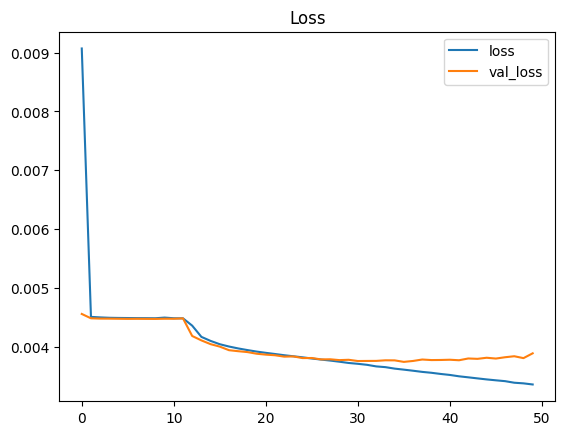

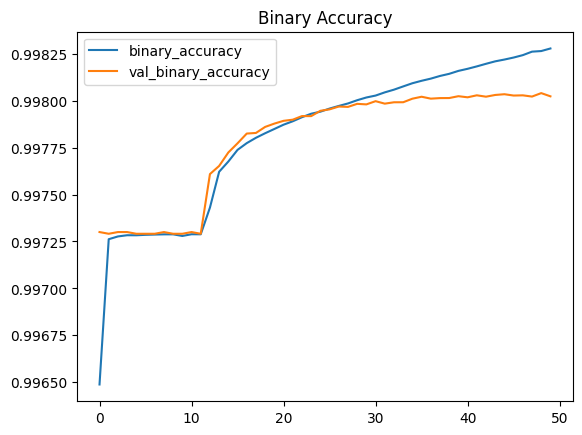

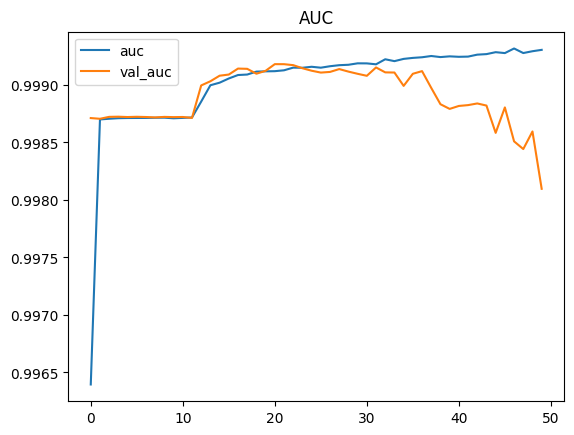

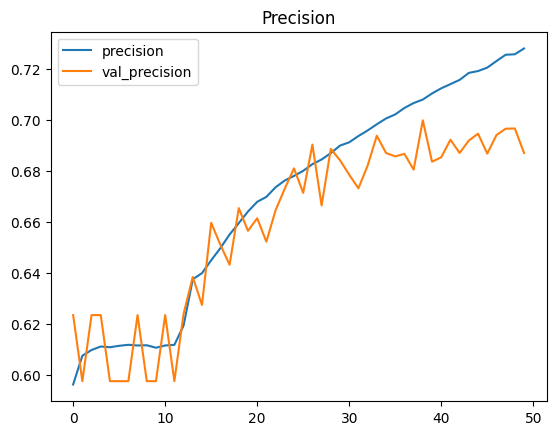

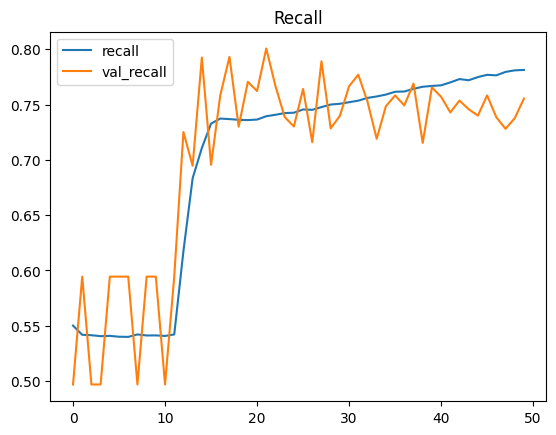

In [ ]:
# Visualize training history
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Binary Accuracy")
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['precision', 'val_precision']].plot(title="Precision")
history_df.loc[:, ['recall', 'val_recall']].plot(title="Recall")

# Prediksi

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import load_model

# Define custom metric functions
def precision(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    true_positives = K.sum(K.cast(K.equal(y_true * y_pred_binary, 1), dtype='float32'))
    predicted_positives = K.sum(y_pred_binary)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    true_positives = K.sum(K.cast(K.equal(y_true * y_pred_binary, 1), dtype='float32'))
    actual_positives = K.sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/TA/Result/Eksperimen2.h5', custom_objects={'precision': precision, 'recall': recall})

# Memuat embeddings data test
test_embeddings = np.load('/content/drive/MyDrive/TA/embedding-T5(PLM)/test_embeds.npy')
test_protein_ids = np.load('/content/drive/MyDrive/TA/embedding-T5(PLM)/test_ids.npy')

# Mengubah bentuk data test sesuai dengan input model
test_df = pd.DataFrame(test_embeddings)
TIMESTEPS = 16
INPUT_SHAPE = (TIMESTEPS, test_df.shape[1] // TIMESTEPS)
test_data_reshaped = test_df.values.reshape((-1, TIMESTEPS, INPUT_SHAPE[1]))

# Lakukan prediksi menggunakan model yang sudah diload
predictions = loaded_model.predict(test_data_reshaped)

# Siapkan DataFrame untuk menyimpan hasil prediksi
df_predik3 = pd.DataFrame(columns=['Protein_ID', 'GO_Term_ID', 'Prediction'])

# Ulangi setiap ID protein untuk setiap label
labels = merged_data['GO_Term_ID'].value_counts().index[:1500].tolist()
l = []
for k in list(test_protein_ids):
    l += [k] * predictions.shape[1]

df_predik3['Protein_ID'] = l
df_predik3['GO_Term_ID'] = labels * len(test_protein_ids)
df_predik3['Prediction'] = predictions.ravel()

# Merge dengan data sequence dan ontology
fasta_path = '/content/drive/MyDrive/TA/Train/train_sequences.fasta'
terms_path = '/content/drive/MyDrive/TA/Train/train_terms.tsv'
fasta_data = pd.DataFrame([(record.id, str(record.seq)) for record in SeqIO.parse(fasta_path, "fasta")], columns=['Protein_ID', 'Sequence'])
terms_data = pd.read_csv(terms_path, sep='\t', header=None, names=['Protein_ID', 'GO_Term_ID', 'Ontology'])

merged_data = pd.merge(terms_data, fasta_data[['Protein_ID', 'Sequence']], on='Protein_ID')
merged_data = merged_data[merged_data.Protein_ID.isin(test_protein_ids)]

merged_final = pd.merge(df_predik3, merged_data[['Protein_ID', 'Sequence', 'GO_Term_ID', 'Ontology']], on=['Protein_ID', 'GO_Term_ID'], how='left')

# Simpan hasil prediksi ke file
merged_final.to_csv("/content/drive/MyDrive/TA/Result/PredikEksperimen2.tsv", header=False, index=False, sep="\t")

In [ ]:
merged_final.head()

,Protein_ID,GO_Term_ID,Prediction,Sequence,Ontology
0,Q9CQV8,GO:0005575,0.761126,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,CCO
1,Q9CQV8,GO:0110165,0.689417,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,CCO
2,Q9CQV8,GO:0008150,0.752356,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,BPO
3,Q9CQV8,GO:0003674,0.742777,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,MFO
4,Q9CQV8,GO:0005622,0.677397,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,CCO
